## Import packages and initial DataFrame

In [1]:
import pandas as pds
import numpy as np
import textdistance
import timeit
import math
import statsmodels.api as sm
import scipy
from patsy import dmatrix
import time
import math
import tqdm
import os
import seaborn as sns
from random import choices
from matplotlib import pyplot as plt

name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)

identifiers = {'was_assigned_female':'strict','country':'strict','birth_year':'strict','id1':'strict','id2':'strict','id3':'strict'} # 'family_name':'jaro-winkler',
true_identifiers = {'was_assigned_female':'strict','country':'strict','birth_year':'strict'} # 'family_name':'jaro-winkler',
covariates = ['X1','X2','X3','X4','X5']

## Generate covariates, treatment and associations with outcome

In [2]:
# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
a = 5.5
b = 0.01
c = 0.08
d = 0.7

ate = a * 2.5
DF['Y'] = - 10 + a*DF['treatment']*DF['X2'] + b*np.exp(DF['X4']) + c*DF['X3']*DF['X1'] + d*DF['X5'] 

# generate new categorical variables for linkage
DF['id1'] = np.random.choice(np.arange(10), size = DF.shape[0]).astype(int)
DF['id2'] = np.random.choice(np.arange(15), size = DF.shape[0]).astype(int)
DF['id3'] = np.random.choice(np.arange(5), size = DF.shape[0]).astype(int)

## Generate subdatasets A and B with common records

In [3]:
common_records = DF.sample(n = 800)

B = pds.concat([DF.sample(n = 1400), common_records]).drop(['Y'], axis = 1)
B = B.reset_index(drop=True)

A = pds.concat([DF.sample(n = 2000), common_records])[list(identifiers.keys())+['Y']]
A = A.reset_index(drop=True)

# delete some family names
A.loc[np.random.choice(np.arange(A.shape[0]), size=250), 'family_name'] = ''
B.loc[np.random.choice(np.arange(B.shape[0]), size=250), 'id1'] = ''
A.loc[np.random.choice(np.arange(A.shape[0]), size=250), 'id3'] = ''
B.loc[np.random.choice(np.arange(B.shape[0]), size=250), 'id2'] = ''

## Write fucntions to compare linking variables among records
- Levenshtein similarity
- Jaro Winkler similarity
- Strict equality
- Large equality

In [4]:
def levenshtein_similarity(a,b):

    """ Check that levenshtein similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if 1 - textdistance.levenshtein(a, b)/max(len(a),len(b)) >= 0.95:
        return 1
    else:
        return 0

def jaro_winkler_similarity(a,b):

    """ Check that jaro-winkler similarity (in [0,1]) is above 0.95.
        
        a: string,
        b: string """

    if textdistance.jaro_winkler(a,b) >= 0.99:
        return 1
    else:
        return 0

def strict_equality(a,b):

    """ Check that a and b values are equal.
        
        a: any value,
        b: any value """

    return a==b

def large_equality(a,b):

    """ Check that years a and b expressed with four numbers are within the same decade.
        
        a: year,
        b: year """

    return str(a)[:-1]==str(b)[:-1]

## Write fucntions to compute the propensity score estimates based on covariates in a DataFrame

In [5]:
def logit(p):
    return np.log(p/(1-p))

def minmaxscaler(X):
    return (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
    
def propensity_score(DF, covariates, scaler, convert_to_logit):
    
    """ Compute propensity score estimates: the probability (logistic regression) that an observation is treated or not conditioned on some covariates.
        These estimates are built conditionaly on covariates passed using a logit after transformation by scaler (when one is specified).
        Estimated probabilities can be converted into logit (convert_to_logit parameter).

        DF:                dataframe,
        covariates:        list of strings for covariates variable in DF,
        scaler:            sklearn.preprocessing function scaler for exemple,
        convert_to_logit:  boolean for converting probabilities to logit when building the propensity score estimates based on a logistic regression
    """
    exog = np.array(DF[covariates])
    if scaler != None:
        exog = scaler(exog)
    intercept = np.ones(DF.shape[0]).reshape(-1,1)
    exog = np.concatenate((exog, intercept), axis=1)
    model = sm.Logit(DF.treatment, exog).fit(disp=0)
    predictions = model.predict(exog)
    if convert_to_logit:
        return logit(predictions)
    else: 
        return predictions

In [6]:
B['propensity_score'] = propensity_score(B, covariates, None, False)

## Compute the cartesian product of all records in A and B
- add the source index (in A or B)
- add the linking score for each pair of records
- compute comparison vectors
- compute the probability of having same linking variables (at all and for matches)

In [7]:
AB = B.merge(A, how='cross', suffixes=("_B", "_A")) # preserve order of left keys: B file
AB["source_index_B"] = np.repeat(B.index, A.shape[0])
AB["source_index_A"] = np.tile(A.index, B.shape[0])

methods = {'jaro-winkler':jaro_winkler_similarity, 'levenshtein':levenshtein_similarity, 'strict':strict_equality, 'large':large_equality}

for linking_var in identifiers.keys():
    method = methods[identifiers[linking_var]]
    df = AB.filter(regex=linking_var)
    AB[linking_var+"_comparison"] = np.array([method(a, b) for a,b in zip(df.iloc[:,0], df.iloc[:,1])]).astype(int).reshape(-1,1)

comparison_vectors_only = AB.filter(regex="comparison")

unmatch = np.array(comparison_vectors_only.sum(axis=0) / len(comparison_vectors_only)) # probability of having same linking var (at all)
match = np.repeat(0.95, len(identifiers.keys())) # probability of having same linking var when being matches

AB["linking_score"] = (np.multiply(comparison_vectors_only, np.log2(match/unmatch)) + np.multiply(1-comparison_vectors_only, np.log2((1-match)/(1-unmatch)))).sum(axis=1)

AB

,name,family_name_B,country_B,birth_year_B,was_assigned_female_B,X1,X2,X3,X4,X5,...,family_name_A,source_index_B,source_index_A,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison,linking_score
0,Gaelle,Mbaye,FR,1978,1,42,4.823948,-1.166895,1.254223,0.174193,...,NaN,0,0,1,0,0,0,0,1,-13.544202
1,Gaelle,Mbaye,FR,1978,1,42,4.823948,-1.166895,1.254223,0.174193,...,NaN,0,1,0,0,0,0,1,0,-15.966571
2,Gaelle,Mbaye,FR,1978,1,42,4.823948,-1.166895,1.254223,0.174193,...,NaN,0,2,0,0,0,0,0,0,-24.196350
3,Gaelle,Mbaye,FR,1978,1,42,4.823948,-1.166895,1.254223,0.174193,...,NaN,0,3,1,0,0,0,0,0,-19.949097
4,Gaelle,Mbaye,FR,1978,1,42,4.823948,-1.166895,1.254223,0.174193,...,NaN,0,4,1,0,0,0,0,0,-19.949097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6159995,Virginie,Lejeune,FR,1978,1,42,1.882542,-0.186890,2.272912,1.071039,...,NaN,2199,2795,1,0,0,1,0,0,-12.351720
6159996,Virginie,Lejeune,FR,1978,1,42,1.882542,-0.186890,2.272912,1.071039,...,NaN,2199,2796,1,0,1,0,1,1,3.557976
6159997,Virginie,Lejeune,FR,1978,1,42,1.882542,-0.186890,2.272912,1.071039,...,NaN,2199,2797,0,0,0,0,0,0,-24.196350
6159998,Virginie,Lejeune,FR,1978,1,42,1.882542,-0.186890,2.272912,1.071039,...,NaN,2199,2798,1,0,0,0,0,1,-13.544202


In [8]:
comparison_vectors_only

,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison
0,1,0,0,0,0,1
1,0,0,0,0,1,0
2,0,0,0,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0
...,...,...,...,...,...,...
6159995,1,0,0,1,0,0
6159996,1,0,1,0,1,1
6159997,0,0,0,0,0,0
6159998,1,0,0,0,0,1


In [9]:
pairs_A = range(A.shape[0]-800, A.shape[0])
pairs_B = range(B.shape[0]-800, B.shape[0])
links = pds.MultiIndex.from_tuples(zip(pairs_A,pairs_B))
pairs = pds.MultiIndex.from_frame(AB[["source_index_A", "source_index_B"]])
comparison_vectors_only[pairs.isin(links)]

,was_assigned_female_comparison,country_comparison,birth_year_comparison,id1_comparison,id2_comparison,id3_comparison
3922000,1,1,1,1,1,0
3924801,1,1,1,1,1,1
3927602,1,1,1,0,1,1
3930403,1,1,1,1,1,1
3933204,1,1,1,1,1,1
...,...,...,...,...,...,...
6148795,1,1,1,1,1,1
6151596,1,1,1,1,1,1
6154397,1,1,1,1,1,1
6157198,1,1,1,1,1,1


## Build the initial linkage
- find perfect comparisons between linking variables
- remove duplicates coming from A or from B
- on linked records, compute the propensity score
- build z0 the initial linkage estimates
- compute the true linkage (based on the common records subdataset built at the start)

For each record in $B$ we find the best match in $A$

Produce the linkage variable $$z_j = \left\{
    \begin{array}{ll}
        i & \text{if } \{i,j\} \text{ are matched} \\
        j + n_A & \text{otherwise.}
    \end{array}
\right.$$

In [10]:
where_good_comparisons = AB[comparison_vectors_only[['was_assigned_female_comparison', 'country_comparison', 'birth_year_comparison', 'id1_comparison', 'id2_comparison', 'id3_comparison']].all(axis=1)] # 'family_name_comparison', 

# remove duplicata: 
where_good_comparisons = where_good_comparisons[ (~where_good_comparisons.source_index_A.duplicated(keep=False)) & (~where_good_comparisons.source_index_B.duplicated(keep=False)) ]

idx_A = where_good_comparisons.source_index_A
idx_B = where_good_comparisons.source_index_B

z_init = -np.ones(B.shape[0])
z_init[idx_B] = idx_A

true_linkage_z = -np.ones(B.shape[0])
true_linkage_z[B.iloc[-800:,:].index] = A.iloc[-800:,:].index

Because the linkage estimate is built by removing duplicates from A and B to enforce 1-2-1 matching we miss some matches and make some errors. We evaluate the proportion of good estimations below:

In [11]:
(z_init == true_linkage_z).sum() / len(true_linkage_z)

0.5540909090909091

## Start

In [31]:
intercept = np.ones(AB.shape[0])
records_treatment =  np.array(AB.treatment)
records_propensity_score = np.array(AB.propensity_score)
interaction_term = records_treatment * records_propensity_score
X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

In [32]:
nbr_iter = 5

pairs = pds.MultiIndex.from_frame(AB[["source_index_A", "source_index_B"]])

dict_empirical_count_linkage = {pair:0 for pair in pairs}

a_sigma, b_sigma, a_sigma2, b_sigma2, a, b, alpha_pi, beta_pi = 1, 1, 1, 1, 1, 1, 1, 1
Betas = scipy.stats.multivariate_normal.rvs(np.array([0,0,0]), np.eye(3))
mu2 = scipy.stats.norm.rvs(0, 1)

new_z = z_init.copy()
# try with a non informative starting linkage variable
# new_z = - np.ones(B.shape[0])
# new_z[-100:] = A.index[-100:] # RMK: cannot start with -1 only, cannpt compute prop score because of perfect separation if no initial sets of links / non links

# PRINT MATRIX LINKAGE
# z_linkage_vector = new_z.copy()
# idx_in_A_links = z_linkage_vector[z_linkage_vector>=0]
# idx_in_B_links = np.nonzero(z_linkage_vector>=0)[0]
# linkage_matrix = np.zeros((B.shape[0], A.shape[0]))
# for link in range(len(idx_in_A_links)):
#     linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1
# sns.heatmap(linkage_matrix)
# plt.title(f"LINKAGE AT START, {(new_z>=0).sum()} links")
# plt.show()

for _ in tqdm.tqdm(range(nbr_iter)):

    ### _ UPDATE INDICES FOR MATCHES
    idx_match_A = new_z[new_z>=0]
    idx_match_B = np.nonzero(new_z>=0)[0]
    links = pds.MultiIndex.from_tuples(zip(idx_match_A,idx_match_B))
    pairs = pds.MultiIndex.from_frame(AB[["source_index_A", "source_index_B"]])

    for link in links:
        dict_empirical_count_linkage[link] += 1

    ### --  UPDATE THETA
    ### --> match, unmatch
    comparison_vectors_for_non_matches = comparison_vectors_only[~pairs.isin(links)]
    unmatch = scipy.stats.beta.rvs(comparison_vectors_for_non_matches.sum(axis=0) + a, (1-comparison_vectors_for_non_matches).sum(axis=0) + b)
    comparison_vectors_for_matches = comparison_vectors_only[pairs.isin(links)]
    match = scipy.stats.beta.rvs(comparison_vectors_for_matches.sum(axis=0) + a, (1-comparison_vectors_for_matches).sum(axis=0) + b)

    ### --  UPDATE COEF OUTCOME MODEL (MATCHES AND NON MATCHES)
    ### --> Betas
    data_for_matches = AB[pairs.isin(links)]
    outcome_for_matches =  np.array(data_for_matches.Y)
    treatment_for_matches =  np.array(data_for_matches.treatment)
    linked_records_propensity_score = propensity_score(data_for_matches, covariates, None, False)
    interaction_term = treatment_for_matches * linked_records_propensity_score
    K = np.concatenate([np.ones(len(outcome_for_matches)).reshape(-1,1), linked_records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)
    n_AB = sum(new_z>=0)
    sigma_square = scipy.stats.invgauss.rvs(a_sigma + n_AB/2, np.linalg.norm(outcome_for_matches - K @ np.array(Betas))**2 / 2 + b_sigma)
    Sigma_beta = np.linalg.inv( (K.T @ K)/sigma_square + np.eye(3) )
    mu_beta = Sigma_beta @ (K.T @ outcome_for_matches)/sigma_square
    Betas = scipy.stats.multivariate_normal.rvs(mu_beta, Sigma_beta)
    ### --> mu2, sigma2_square
    data_for_non_matches = AB[~pairs.isin(links)]
    outcome_for_non_matches =  np.array(data_for_non_matches.Y)
    n_AB = sum(new_z>=0)
    sigma2_square = scipy.stats.invgauss.rvs(a_sigma2 + (A.shape[0] - n_AB)/2, b_sigma2 + sum((outcome_for_non_matches - mu2)**2)/2)
    sigma_mu2_square = 1/((A.shape[0] - n_AB)/sigma2_square + 1)
    m_mu2 = sigma_mu2_square * (outcome_for_non_matches).sum() / sigma2_square
    mu2 = scipy.stats.norm.rvs(m_mu2, np.sqrt(sigma_mu2_square))
    ### --> outcome model distribution
    residuals = AB.Y - X @ Betas.T
    estimated_variance = residuals.T @ residuals / (len(residuals) - (X.shape[1]+1))
    distr_linked_outcomes = scipy.stats.norm.pdf(residuals, 0, np.sqrt(estimated_variance))
    distr_non_linked_outcomes = scipy.stats.norm.pdf(AB.Y, mu2, np.sqrt(sigma2_square)) # scipy.stats.norm.rvs(0, 1), 10000)

    ### --  UPDATE PROBABILITIES
    w1 = ( np.multiply( comparison_vectors_only, np.log(match/unmatch) ) + np.multiply( 1-comparison_vectors_only, np.log((1-match)/(1-unmatch)) ) ).sum(axis=1)
    w2 = np.log(distr_linked_outcomes / distr_non_linked_outcomes)
    probabilities = np.array(np.exp(w1+w2))
    probabilities = probabilities.reshape(B.shape[0], A.shape[0])

    # beta_pi = int(probabilities.max()) * 0.05 # TO DO: DISCUSS AND MOTIVATE

    probabilities_to_print = probabilities.copy()
    probabilities_to_print = np.divide(probabilities_to_print.T, probabilities_to_print.sum(axis=1)).T
    # sns.heatmap(probabilities_to_print)
    # plt.title("PROBABILITIES")
    # plt.show()

    for j in range(B.shape[0]):

        n_AB_ = (np.delete(new_z, j)>=0).sum()
        proba_for_unmatch = (A.shape[0] - n_AB_) * (B.shape[0] - n_AB_ - 1 + beta_pi) / (n_AB_ + alpha_pi)

        not_possible_values = list( set(np.delete(new_z, j).astype(int)) - set([-1]) )
        proba = probabilities[j,:].copy()
        
        proba[not_possible_values]  = 0
        proba = np.append(proba, proba_for_unmatch)

        idx_max_proba = np.argpartition(proba, -5)[-5:]
        possible_values = np.arange(A.shape[0])
        possible_values = np.append(possible_values, -1)

        val1 = choices(possible_values[idx_max_proba], weights = proba[idx_max_proba])[0]

        # RMK: more non links with val1, see later how to process
        #val2 = choices(possible_values, weights = proba)[0]
        #print("val1",val1)
        #print("val2",val2)

        new_z[j] = val1

    # RMK: print matrix linkage based on z:
    # z_linkage_vector = new_z.copy()

    # idx_in_A_links = z_linkage_vector[z_linkage_vector>=0]
    # idx_in_B_links = np.nonzero(z_linkage_vector>=0)[0]
    # linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

    # for link in range(len(idx_in_A_links)):
    #     linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1

    # sns.heatmap(linkage_matrix)
    # plt.title(f"LINKAGE AT THE END, {(new_z>=0).sum()} links")
    # plt.show()

100%|██████████| 5/5 [00:21<00:00,  4.34s/it]


- tends to link all records in B with a record in A for eahc iteration
- not a problem because in the end we look at the most matched pairs of records
- we can force the algo not to link all records in B playing with beta_pi (see commented row in the code)
- 4 minutes per iteration (update all param + the linkage variable z)
- probabilities are high for paris of records that make sense (checked!)
- try to parallelize the gibbs sampler: multiprocessing?
- find a way to compute true links made

[0.  0.2 0.4 0.6 0.8 1. ]


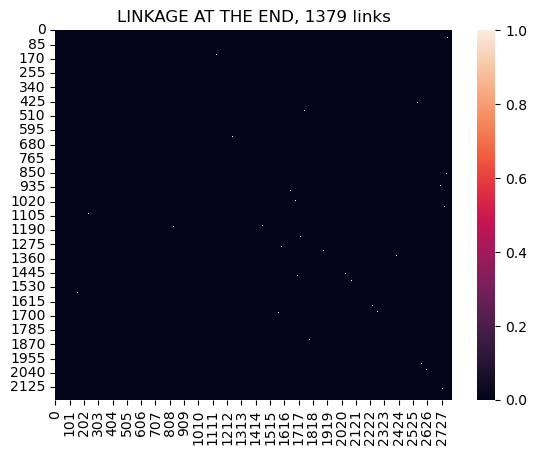

In [33]:
v = np.array(list(dict_empirical_count_linkage.values())) / nbr_iter
k = np.array(list(dict_empirical_count_linkage.keys()))
print(np.unique(v))
emp_max = np.max(np.unique(v))
best = k[v>=0.8]

idx_in_A_links = best[:,0]
idx_in_B_links = best[:,1]

z_final = - np.ones(B.shape[0])
z_final[idx_in_B_links] = idx_in_A_links

linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in range(len(idx_in_A_links)):
    linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1

sns.heatmap(linkage_matrix)
plt.title(f"LINKAGE AT THE END, {(linkage_matrix==1).sum()} links")
plt.show()

In [35]:
t = np.array([[0,0]])
np.concatenate([t, best])

array([[   0,    0],
       [1444,    0],
       [ 329,    1],
       ...,
       [2795, 2195],
       [2797, 2197],
       [1122, 2198]])

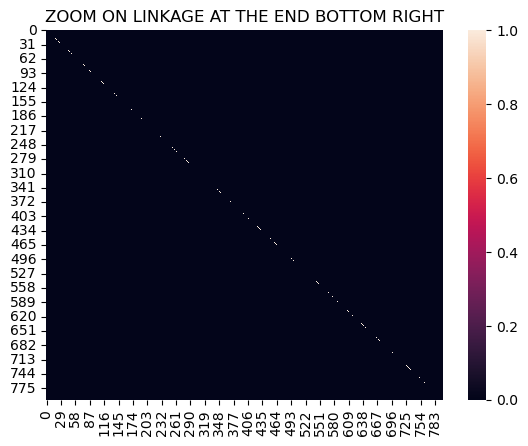

In [15]:
sns.heatmap(linkage_matrix[1400:,2000:])
plt.title(f"ZOOM ON LINKAGE AT THE END BOTTOM RIGHT")
plt.show()

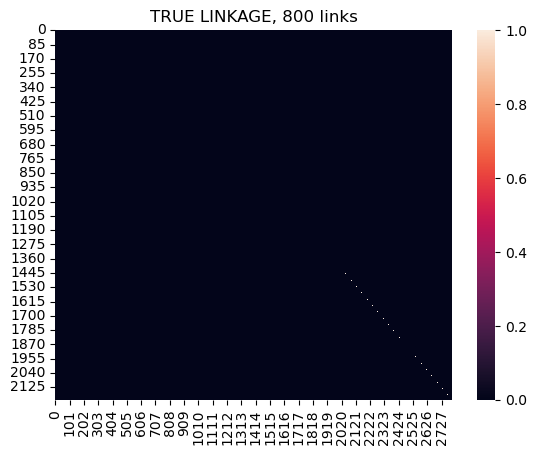

In [16]:
z_linkage_vector = true_linkage_z.copy()

idx_in_A_links = z_linkage_vector[z_linkage_vector>=0]
idx_in_B_links = np.nonzero(z_linkage_vector>=0)[0]
linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in range(len(idx_in_A_links)):
    linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1

sns.heatmap(linkage_matrix)
plt.title(f"TRUE LINKAGE, {(linkage_matrix==1).sum()} links")
plt.show()

In [25]:
(z_final == true_linkage_z).sum() / len(true_linkage_z)

0.45136363636363636

## End

In [12]:
intercept = np.ones(AB.shape[0])
records_treatment =  np.array(AB.treatment)
records_propensity_score = np.array(AB.propensity_score)
interaction_term = records_treatment * records_propensity_score
X = np.concatenate([intercept.reshape(-1,1), records_propensity_score.reshape(-1,1), interaction_term.reshape(-1,1)], axis=1)

In [13]:
params = {'cartesian_product_AB': AB,'z_init': z_init,'comparison_vectors': comparison_vectors_only,'covariates': covariates,'n_A': A.shape[0],'n_B': B.shape[0],'X': X}

In [14]:
from multiprocessing.pool import Pool
import defs

if __name__ == "__main__":
    n_mcmc = 8 # The number of concurrent MCMCs
    mcmc_params = []
    for i in range(n_mcmc):
        tmp = params.copy()
        mcmc_params.append(tmp)

    with Pool(processes=n_mcmc) as pool:
        results = pool.map(defs.mcmc_func, mcmc_params)

100%|██████████| 500/500 [3:08:36<00:00, 22.63s/it]


190 minutes!!!

In [25]:
linked_records = set()
for coeur in results:
    for pair in coeur:
        linked_records.add(tuple(pair))
linked_records

{(2775, 2175),
 (723, 220),
 (1499, 441),
 (2280, 1680),
 (1184, 694),
 (2010, 1410),
 (1433, 123),
 (1492, 172),
 (420, 74),
 (2314, 1714),
 (881, 140),
 (153, 484),
 (1659, 1337),
 (2463, 1019),
 (1405, 783),
 (2044, 1444),
 (1624, 858),
 (1959, 848),
 (294, 873),
 (2380, 1780),
 (2278, 1323),
 (508, 1067),
 (1283, 1323),
 (2143, 1543),
 (758, 949),
 (2750, 6),
 (58, 229),
 (62, 199),
 (2446, 1846),
 (2479, 1879),
 (389, 450),
 (1606, 822),
 (1675, 513),
 (660, 535),
 (628, 1369),
 (1459, 1297),
 (1918, 499),
 (2512, 1912),
 (41, 1200),
 (2210, 1610),
 (2564, 1964),
 (2459, 1124),
 (793, 1185),
 (2294, 1694),
 (1931, 330),
 (2597, 1997),
 (16, 855),
 (1510, 422),
 (2051, 1451),
 (783, 438),
 (883, 296),
 (1995, 1784),
 (2117, 1517),
 (2696, 2096),
 (2168, 1568),
 (2150, 1550),
 (742, 69),
 (2729, 2129),
 (2711, 2111),
 (2290, 626),
 (916, 1124),
 (1760, 1220),
 (2216, 1616),
 (2513, 182),
 (320, 726),
 (2796, 2196),
 (1306, 533),
 (570, 1102),
 (2571, 1031),
 (882, 205),
 (1237, 253)

In [31]:
linked_records = dict()
for coeur in results:
    for pair in coeur:
        if tuple(pair) not in linked_records:
            linked_records[tuple(pair)] = 1
        else:
            linked_records[tuple(pair)] = linked_records[tuple(pair)] + 1
linked_records

{(1144, 1): 8,
 (1549, 4): 8,
 (2750, 6): 5,
 (578, 7): 8,
 (1274, 12): 8,
 (148, 13): 8,
 (1704, 17): 8,
 (873, 18): 8,
 (1837, 21): 8,
 (2001, 22): 8,
 (229, 28): 8,
 (1321, 30): 8,
 (1638, 31): 8,
 (1096, 38): 8,
 (280, 39): 8,
 (1954, 40): 8,
 (1251, 42): 8,
 (1557, 43): 8,
 (2689, 44): 6,
 (371, 46): 8,
 (1757, 49): 8,
 (932, 51): 8,
 (697, 52): 6,
 (2742, 54): 5,
 (1667, 55): 8,
 (1839, 56): 8,
 (1112, 58): 8,
 (1053, 60): 8,
 (1162, 64): 8,
 (838, 65): 8,
 (2083, 67): 6,
 (377, 68): 4,
 (742, 69): 8,
 (420, 74): 8,
 (363, 75): 8,
 (1665, 76): 8,
 (426, 81): 8,
 (1107, 82): 8,
 (1937, 83): 8,
 (366, 84): 8,
 (2778, 86): 8,
 (1861, 87): 8,
 (147, 88): 8,
 (869, 90): 8,
 (2226, 92): 8,
 (1058, 96): 8,
 (2129, 98): 4,
 (997, 99): 8,
 (1643, 100): 8,
 (2664, 101): 8,
 (2134, 103): 2,
 (2638, 105): 2,
 (1366, 107): 5,
 (1546, 109): 7,
 (85, 110): 8,
 (2607, 113): 8,
 (138, 114): 8,
 (1318, 116): 8,
 (1968, 117): 8,
 (223, 118): 6,
 (1433, 123): 8,
 (500, 124): 8,
 (1116, 126): 5,
 (96

In [34]:
np.unique(np.array(list(linked_records.values())))

array([1, 2, 3, 4, 5, 6, 7, 8])

In [38]:
linkage_matrix = np.zeros((B.shape[0], A.shape[0]))

for link in [k for k,v in linked_records.items() if v == 8]:
    A_idx = link[0]
    B_idx = link[1]
    linkage_matrix[B_idx, A_idx] = 1

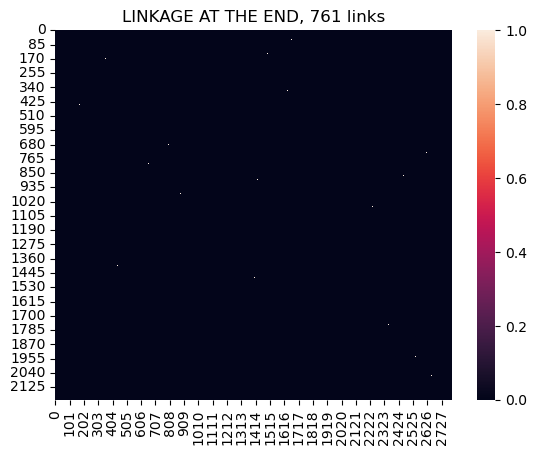

In [39]:
sns.heatmap(linkage_matrix)
plt.title(f"LINKAGE AT THE END, {(linkage_matrix==1).sum()} links")
plt.show()